<a href="https://colab.research.google.com/github/IgorvH-Developer/Heart_Failure_Prediction/blob/main/Heart_Failure_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sn

from google.colab import drive

In [ ]:
device = torch.device("cuda")

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
dataExcelTable = pd.read_excel('/content/drive/MyDrive/Heart Failure Prediction/heart(Excel).xlsx') 

In [ ]:
dataExcelTable

,Age,Sex_Male,Sex_Female,ChestPainType_TA,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_ASY,RestingBP,Cholesterol,FastingBS,RestingECG_Norm,RestingECG_ST,RestingECG_LVH,MaxHR,ExerciseAngina,Oldpeak,ST_Slope_Up,ST_Slope_Flat,ST_Slope_Down,HeartDisease
0,0.24,1,0,0,1,0,0,0.480,0.38600,0,1,0,0,0.784,0,0.2964,1,0,0,0
1,0.42,0,1,0,0,1,0,0.640,0.17563,0,1,0,0,0.672,0,0.4104,0,1,0,1
2,0.18,1,0,0,1,0,0,0.400,0.37442,0,0,1,0,0.266,0,0.2964,1,0,0,0
3,0.40,0,1,0,0,0,1,0.464,0.24125,0,1,0,0,0.336,1,0.4674,0,1,0,1
4,0.52,1,0,0,0,1,0,0.560,0.20458,0,1,0,0,0.434,0,0.2964,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,0.34,1,0,1,0,0,0,0.240,0.33775,0,1,0,0,0.504,0,0.4332,0,1,0,1
742,0.80,1,0,0,0,0,1,0.512,0.20072,1,1,0,0,0.567,0,0.6840,0,1,0,1
743,0.58,1,0,0,0,0,1,0.400,0.08106,0,1,0,0,0.385,1,0.4332,0,1,0,1
744,0.58,0,1,0,1,0,0,0.400,0.28371,0,0,0,1,0.798,0,0.2964,0,1,0,1


In [ ]:
dataTensor = torch.tensor(dataExcelTable.values)
dataX = dataTensor[:,:19]
dataY = torch.zeros((746,2))
for i in range(746):
  if (dataTensor[i,19] == 1):
    dataY[i] = torch.tensor([1,0])
  else:
    dataY[i] = torch.tensor([0,1])
print(dataX.shape)
print(dataY)

torch.Size([746, 19])
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        ...,
        [1., 0.],
        [1., 0.],
        [0., 1.]])


# Разделяем данные на 3  датасета:

In [ ]:
dataXTrain = dataX[:600, [4,6,13,14,15,16,17]]          # Датасеты с 7-ю признаками
dataYTrain = dataY[:600]
dataXValid = dataX[600:700, [4,6,13,14,15,16,17]]
dataYValid = dataY[600:700]
dataXTest = dataX[700:746, [4,6,13,14,15,16,17]]
dataYTest = dataY[700:746]

In [ ]:
dataXTrain = dataX[:600]        # Датасеты с 19-ю признаками
dataYTrain = dataY[:600]
dataXValid = dataX[600:700]
dataYValid = dataY[600:700]
dataXTest = dataX[700:746]
dataYTest = dataY[700:746]

# Матрица корреляции:

,Age,Sex_Male,Sex_Female,ChestPainType_TA,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_ASY,RestingBP,Cholesterol,FastingBS,RestingECG_Norm,RestingECG_ST,RestingECG_LVH,MaxHR,ExerciseAngina,Oldpeak,ST_Slope_Up,ST_Slope_Flat,ST_Slope_Down,HeartDisease
Age,1.000000,0.040917,-0.040917,0.050671,-0.229820,-0.022271,0.186737,0.259865,0.058802,0.241338,-0.238592,0.109853,0.179061,-0.382112,0.245908,0.286006,-0.272296,0.202548,0.148987,0.298617
Sex_Male,0.040917,1.000000,-1.000000,0.013732,-0.138835,-0.080302,0.176468,0.034363,-0.107019,0.096075,-0.002763,0.037574,-0.029859,-0.157002,0.192579,0.125743,-0.136713,0.102288,0.073531,0.292779
Sex_Female,-0.040917,-1.000000,1.000000,-0.013732,0.138835,0.080302,-0.176468,-0.034363,0.107019,-0.096075,0.002763,-0.037574,0.029859,0.157002,-0.192579,-0.125743,0.136713,-0.102288,-0.073531,-0.292779
ChestPainType_TA,0.050671,0.013732,-0.013732,1.000000,-0.129014,-0.130513,-0.239224,0.065069,-0.050287,0.049295,-0.053437,0.002048,0.059945,0.091131,-0.118155,0.042978,-0.002133,-0.017147,0.041306,-0.053765
ChestPainType_ATA,-0.229820,-0.138835,0.138835,-0.129014,1.000000,-0.289531,-0.530697,-0.076092,-0.015998,-0.093325,0.131242,-0.032920,-0.122691,0.243329,-0.317049,-0.303200,0.363901,-0.314773,-0.104655,-0.375634
ChestPainType_NAP,-0.022271,-0.080302,0.080302,-0.130513,-0.289531,1.000000,-0.536862,-0.054299,-0.068506,0.005850,0.027344,-0.062745,0.023598,0.152321,-0.197576,-0.135819,0.115120,-0.091037,-0.051406,-0.222146
ChestPainType_ASY,0.186737,0.176468,-0.176468,-0.239224,-0.530697,-0.536862,1.000000,0.079102,0.093584,0.050270,-0.107715,0.078984,0.054987,-0.371491,0.483025,0.346352,-0.398138,0.345895,0.111273,0.522982
RestingBP,0.259865,0.034363,-0.034363,0.065069,-0.076092,-0.054299,0.079102,1.000000,0.095894,0.173765,-0.086085,0.086690,0.023214,-0.125774,0.161035,0.198575,-0.127077,0.081746,0.096915,0.173242
Cholesterol,0.058802,-0.107019,0.107019,-0.050287,-0.015998,-0.068506,0.093584,0.095894,1.000000,0.053985,-0.046887,-0.028853,0.079558,-0.019861,0.086717,0.058426,-0.098990,0.103935,-0.010759,0.103804
FastingBS,0.241338,0.096075,-0.096075,0.049295,-0.093325,0.005850,0.050270,0.173765,0.053985,1.000000,-0.165081,0.135072,0.071935,-0.102710,0.109995,0.055568,-0.147309,0.105542,0.089243,0.160594


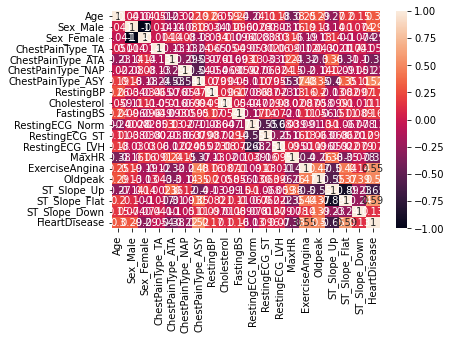

In [ ]:
corrMatr = dataExcelTable.corr()
sn.heatmap(corrMatr, annot=True)

corrMatr

# Архитектура нейронной сети:


In [ ]:
class HeartFailurePrediction(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(HeartFailurePrediction, self).__init__()
        self.fc1 = torch.nn.Linear(7, n_hidden_neurons)
        self.act1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.act2 = torch.nn.ReLU()
        self.fc5 = torch.nn.Linear(n_hidden_neurons, 2)

    def forward(self, x):
        x = self.act1(
            self.fc1(x))
        x = self.act2(
            self.fc2(x))
        x = self.fc5(x)
        x = nn.functional.softmax(x, dim=1)
        return x

    def loss(self, pred, targets):
        return nn.BCELoss()(pred.float(), targets.float())

NameError: ignored

In [ ]:
predictionNet = HeartFailurePrediction(n_hidden_neurons=5)

# Обучение:

In [ ]:
optimizer = torch.optim.Adam(predictionNet.parameters(), 
                             lr=0.0001)    
batch_size = 600
loss_metric_history = torch.zeros(4,70)
for epoch in range(20000):
    order = np.random.permutation(len(dataXTrain))
    for start_index in range(0, len(dataXTrain), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = dataXTrain[batch_indexes]
        y_batch = dataYTrain[batch_indexes]
        
        preds = predictionNet.forward(x_batch.float()) 

        loss_value = predictionNet.loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 1000 == 0:
        train_preds = predictionNet.forward(dataXTrain.float())
        acuracyTrain = (train_preds.round()[:,0] == dataYTrain[:,0]).double().sum() / len(dataYTrain[:,0])
        valid_preds = predictionNet.forward(dataXValid.float())
        acuracyValid = (valid_preds.round()[:,0] == dataYValid[:,0]).double().sum() / len(dataYValid[:,0])
        loss_metric_history[0,epoch // 1000] = loss_value.data.numpy().tolist()
        loss_metric_history[1,epoch // 1000] = acuracyTrain.numpy().tolist()
        loss_metric_history[2,epoch // 1000] = predictionNet.loss(valid_preds, dataYValid).data.numpy().tolist()
        loss_metric_history[3,epoch // 1000] = acuracyValid.numpy().tolist()

        print('loss_Valid:',loss_metric_history[2,epoch // 1000].numpy().tolist(),'lossTrain:', loss_metric_history[0,epoch // 1000].numpy().tolist(), 
              'trainAcc:', loss_metric_history[1,epoch // 1000].numpy().tolist())

loss_Valid: 0.6877243518829346 lossTrain: 0.6961461901664734 trainAcc: 0.5199999809265137
loss_Valid: 0.678276538848877 lossTrain: 0.6741887331008911 trainAcc: 0.5199999809265137
loss_Valid: 0.5692312717437744 lossTrain: 0.5027726292610168 trainAcc: 0.8633333444595337
loss_Valid: 0.5110718607902527 lossTrain: 0.38810789585113525 trainAcc: 0.8616666793823242
loss_Valid: 0.49247437715530396 lossTrain: 0.34563708305358887 trainAcc: 0.8616666793823242
loss_Valid: 0.4639926552772522 lossTrain: 0.33643603324890137 trainAcc: 0.8733333349227905
loss_Valid: 0.44917404651641846 lossTrain: 0.3322643041610718 trainAcc: 0.8766666650772095
loss_Valid: 0.44314661622047424 lossTrain: 0.3284921944141388 trainAcc: 0.8766666650772095
loss_Valid: 0.44166961312294006 lossTrain: 0.3242656886577606 trainAcc: 0.8766666650772095
loss_Valid: 0.4406445324420929 lossTrain: 0.3200186789035797 trainAcc: 0.8766666650772095
loss_Valid: 0.4391838312149048 lossTrain: 0.3152525722980499 trainAcc: 0.878333330154419
loss_

In [ ]:
torch.save(predictionNet.state_dict(),'/content/drive/MyDrive/Heart Failure Prediction/HeartFailurePredictionWeights.py')

#Метрика тестового датасета:

In [ ]:
test_preds_test = predictionNet.forward(dataXTest.float())                
acuracy = (test_preds_test.round()[:,0] == dataYTest[:,0]).double().sum() / len(dataYTest[:,0])
print('acuracyTest:', acuracy.numpy().tolist())                     

acuracyTest: 0.717391304347826


# График изменения метрик и функций потерь:
#зелёный - метрика(train), синий - метрика(valid), жёлтый - функ. потерь(valid), красный - функ. потерь(train))

torch.Size([4, 70])

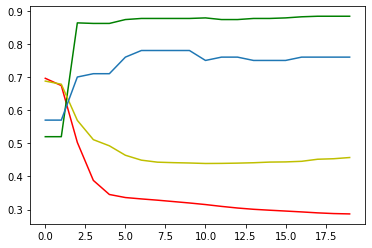

In [ ]:
plt.plot(loss_metric_history[0,:20],'r',loss_metric_history[1,:20],'g',loss_metric_history[2,:20],'y', loss_metric_history[3,:20])
loss_metric_history.shape